# Preprocessing
leggo i file wav del dataset originale <a href="https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification">GTZAN Dataset - Music Genre Classification</a>, in particolare le 2 directory contenenti i generi che mi interessano per questo esperimento:
- Classica
- Metal

In [ ]:
from src.preprocess import preprocess
import numpy as np

In [ ]:
preprocessor = preprocess.MusicPreprocessor(
    sample_rate=22050,
    segment_duration=5.0,
    spectrogram_size=(128, 512) # This will be the size for BOTH Mel and CQT
)

# 2. preprocessa i dati dalle 2 directory contenenti i geeri scelti 
genre_a_dir = "PathAllaTuaDirecctory/Classica"
genre_b_dir = "PathAllaTuaDirecctory/Classica"

specs_a, info_a = preprocessor.process_genre_directory(genre_a_dir, 'genre_a')
specs_b, info_b = preprocessor.process_genre_directory(genre_b_dir, 'genre_b')


# 3. Calcola e salva le statistiche e normalizza entrambi i dataset con le stesse statistiche 
combined_specs = np.concatenate([specs_a, specs_b], axis=0)
preprocessor.compute_dataset_statistics(combined_specs)

#normalizatione
normalized_specs_a = np.array([preprocessor.normalize_spectrogram(s) for s in specs_a])
normalized_specs_b = np.array([preprocessor.normalize_spectrogram(s) for s in specs_b])

# 4. salva i dati processati
preprocessor.save_processed_data(normalized_specs_a, info_a, 'Classical_processed.h5', 'genre_a')
preprocessor.save_processed_data(normalized_specs_b, info_b, 'Metal_processed.h5', 'genre_b')


Processing 100 files for genre: genre_a
  - Processing 100/100: classical.00099.wav
Finished processing for genre_a. Generated 1093 samples.
Processing 100 files for genre: genre_b
  - Processing 100/100: metal.00099.wav
Finished processing for genre_b. Generated 1100 samples.
Mel Stats: Mean=0.3547, Std=0.6800
CQT Stats: Mean=0.2350, Std=0.2870


## Divido i dati processati in Train/Test e li metto in un tensore tensorflow per essere utilizzati dal modello

In [ ]:
from src.loader import dataLoader

In [ ]:
# paths contenenti HDF5 files con i dati processati
genre_a_h5_file = 'Classical_processed.h5'
genre_b_h5_file = 'Metal_processed.h5'

# Instanzia il data loader
data_loader = dataLoader.MusicDataLoader(
    data_file_a=genre_a_h5_file,
    data_file_b=genre_b_h5_file,
    batch_size=2, 
    train_split=0.8,
    val_split=0.2
)

# dataset pronti ad essere utilizzati dal modello
datasets = data_loader.get_datasets()
train_A = datasets['train_A']
train_B = datasets['train_B']

Loading data for genre_a from Classical_processed.h5...
Loaded genre_a: (1093, 128, 512, 2)
Loading data for genre_b from Metal_processed.h5...
Loaded genre_b: (1100, 128, 512, 2)
Creating train/validation splits...
Genre A - Train: 874, Val: 219
Genre B - Train: 880, Val: 220


# Modelli

In [ ]:
from src.models import generator,discriminator,cyclegan

In [ ]:
#Dimensione input
IMG_SHAPE_Disc = (128, 512, 1)
SHAPE_Gen = (128, 512, 2)
# Parametri di Allenamento
EPOCHS = 100
STEPS_PER_EPOCH = 437  # perchè il batchsize è posto a 2
LAMBDA_CYCLE = 10.0
LAMBDA_IDENTTITY = 1.0

# calcolo step totali per il decadimento del learning rate
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH
# inizio decadimento del learning rate
DECAY_START_STEP = 0.6*TOTAL_STEPS  #epoca 60


## Istanzio i modelli dei generatori e discriminatori utilizzati dalla CycleGan

In [ ]:
gen_AB = generator.generator_with_dilated_cnn(input_shape=SHAPE_Gen, name="G_Classical_To_Metal")
gen_BA = generator.generator_with_dilated_cnn(input_shape=SHAPE_Gen, name="F_Metal_To_Classical")
disc_A = discriminator.discriminator_spectral(input_shape=IMG_SHAPE_Disc, name="D_Classical")
disc_B = discriminator.discriminator_spectral(input_shape=IMG_SHAPE_Disc, name="D_Metal")

## Instanzio la CycleGan

In [ ]:
cycle_gan_model = cyclegan.CycleGAN(
    generator_AB=gen_AB,
    generator_BA=gen_BA,
    discriminator_A=disc_A,
    discriminator_B=disc_B,
    lambda_cycle=LAMBDA_CYCLE,
    lambda_identity_start=LAMBDA_IDENTTITY,
    
    total_train_steps=TOTAL_STEPS,
    lr_decay_start_step=DECAY_START_STEP,
    
    initial_gen_lr=2e-4,
    initial_disc_lr=1e-4 #metà rispetto al generatore
)

### Allenamento dell' intera rete (generatori e discriminatori)

In [ ]:
cycle_gan_model.train(
    train_A, 
    train_B, 
    epochs=EPOCHS, 
    steps_per_epoch=STEPS_PER_EPOCH,
    checkpoint_dir='./CheckpointsClassicalMetal',
    sample_dir='./samplesClassicalMetal'
)

Epoch 1/60
Step 0: Gen Loss: 6.6635, Disc Loss: 0.2151, Cycle Loss: 0.5112,Identity Loss: 0.5259 
Step 100: Gen Loss: 5.9966, Disc Loss: 0.2400, Cycle Loss: 0.4448,Identity Loss: 0.4593 
Step 200: Gen Loss: 5.8286, Disc Loss: 0.2431, Cycle Loss: 0.4313,Identity Loss: 0.4437 
Step 300: Gen Loss: 5.7876, Disc Loss: 0.2447, Cycle Loss: 0.4281,Identity Loss: 0.4397 
Step 400: Gen Loss: 5.7441, Disc Loss: 0.2463, Cycle Loss: 0.4248,Identity Loss: 0.4360 
Epoch 2/60
Step 0: Gen Loss: 5.4657, Disc Loss: 0.2654, Cycle Loss: 0.3912,Identity Loss: 0.3970 
Step 100: Gen Loss: 5.6677, Disc Loss: 0.2517, Cycle Loss: 0.4195,Identity Loss: 0.4299 
Step 200: Gen Loss: 5.7521, Disc Loss: 0.2494, Cycle Loss: 0.4266,Identity Loss: 0.4361 
Step 300: Gen Loss: 5.6400, Disc Loss: 0.2491, Cycle Loss: 0.4164,Identity Loss: 0.4251 
Step 400: Gen Loss: 5.6705, Disc Loss: 0.2487, Cycle Loss: 0.4191,Identity Loss: 0.4272 
Epoch 3/60
Step 0: Gen Loss: 7.1976, Disc Loss: 0.2282, Cycle Loss: 0.5566,Identity Loss: 0.

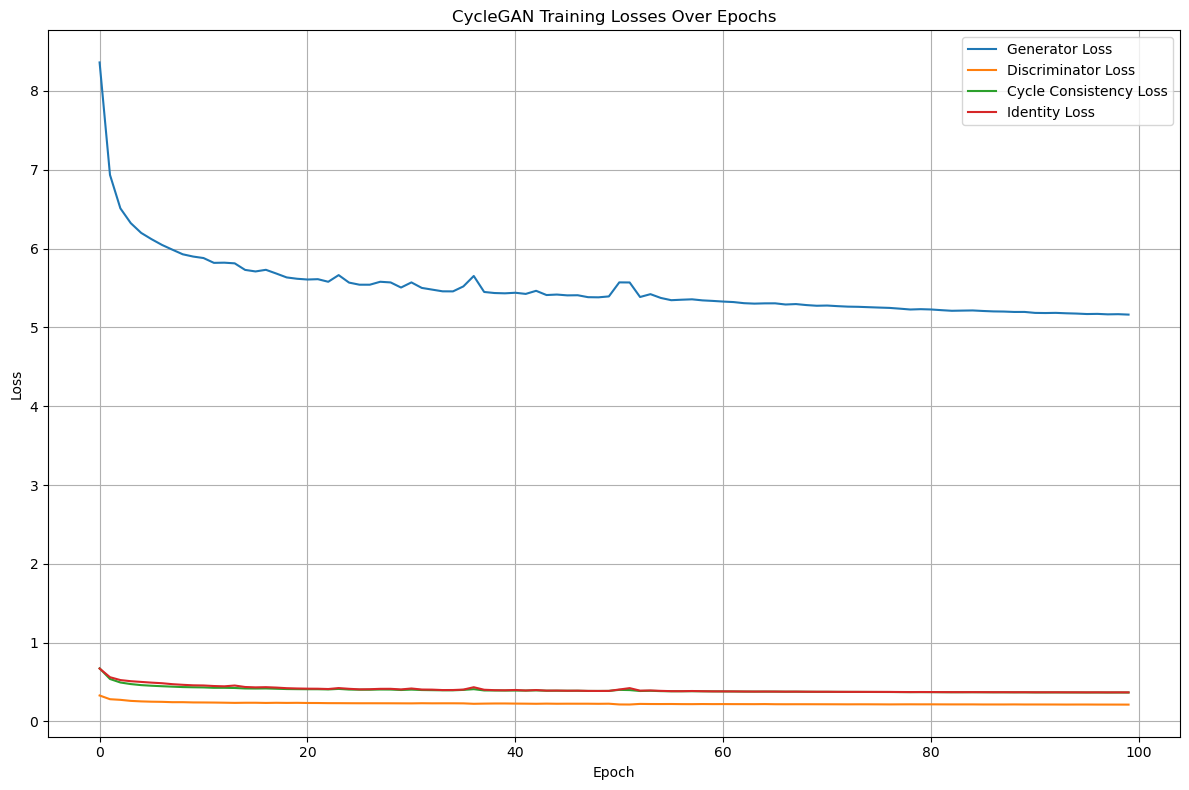

In [ ]:
cycle_gan_model.plot_training_losses()

# Post processing

Utilizzo l'algoritmo Griffin-Lim per ricostruire l'audio a partire dagli spettrogrammi generati dalla rete

In [ ]:
from src.postprocess import reconstruct

reconstructor=reconstruct.MusicReconstructor(global_mean=0.3547,global_std=0.6800) #valori calcolati in fase di preprocessing

### ricostruisco l'audio e salvo tutti gli elementi (originali e tradotti) del test set

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def Save_Plot_Cycle(x,y,x_tradotto,y_tradotto,x_rigenerato,y_rigenerato,num,save_dir):
        """
        Genera e salva un plot degli spettrogrammi originali, trasformati, ciclati e della
        differenza tra originale e ciclato
        """
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))

        # Prima Riga: Classica -> finto Metal metal -> Classica
        axes[0, 0].imshow(x.numpy().squeeze(), aspect='auto', cmap='viridis')
        axes[0, 0].set_title('Real Classical')
        axes[0, 1].imshow(x_tradotto.numpy().squeeze(), aspect='auto', cmap='viridis')
        axes[0, 1].set_title('Fake Metal')
        axes[0, 2].imshow(x_rigenerato.numpy().squeeze(), aspect='auto', cmap='viridis')
        axes[0, 2].set_title('Cycled Classical')
        axes[0, 3].imshow((x - x_rigenerato).numpy().squeeze(), aspect='auto', cmap='viridis')
        axes[0, 3].set_title('Difference')

        # Seconda Riga: Metal -> finta Classica -> Metal
        axes[1, 0].imshow(y.numpy().squeeze(), aspect='auto', cmap='viridis')
        axes[1, 0].set_title('Real Metal')
        axes[1, 1].imshow(y_tradotto.numpy().squeeze(), aspect='auto', cmap='viridis')
        axes[1, 1].set_title('Fake Classical')
        axes[1, 2].imshow(y_rigenerato.numpy().squeeze(), aspect='auto', cmap='viridis')
        axes[1, 2].set_title('Cycled Metal')
        axes[1, 3].imshow((y - y_rigenerato).numpy().squeeze(), aspect='auto', cmap='viridis')
        axes[1, 3].set_title('Difference')
        
        plt.tight_layout()
        plt.savefig(f"{save_dir}/Test_{num}.png")
        plt.close()

In [ ]:
# ricreo l'audio e stampo un plot di tutti gli elementi (originali e tradotti) del Test set
test_A = datasets["val_A"]
test_B = datasets["val_B"]
num=0
# Iterate through all batches in both test sets
for x, y in zip(test_A, test_B):

    x_tradotto=cycle_gan_model.gen_AB(x)
    y_tradotto=cycle_gan_model.gen_BA(y)

    
    x_rigenerato =cycle_gan_model.gen_BA(x_tradotto, training=False)
    y_rigenerato = cycle_gan_model.gen_AB(y_tradotto, training=False)

    x_mel = x[..., 0:1] 
    y_mel = y[..., 0:1] 
    x_tradotto_mel = x_tradotto[..., 0:1] 
    y_tradotto_mel = y_tradotto[..., 0:1] 
    x_rigenerato_mel = x_rigenerato[..., 0:1] 
    y_rigenerato_mel = y_rigenerato[..., 0:1] 

    for i in range (2): #perchè ho utilizzato batchsize pari a 2

        #stampa e salva l'immagine
        Save_Plot_Cycle(x_mel[i],y_mel[i],x_tradotto_mel[i],y_tradotto_mel[i],x_rigenerato_mel[i],y_rigenerato_mel[i],num,save_dir="./PlotsClassicalMetal/plotsMelAndQLessNoise")
        
        #ricostruisco audio del segmento di musica classica originale e lo salvo
        reconstructor.reconstruct_and_save(
        input_spectrogram=x_mel[i].numpy().squeeze(),
        output_path=f"./AudioClassicalMetal/ClassicalQlessNoise/originale/originale_{num}.wav")
        #ricostruisco audio del segmento di musica classica tradotta in metal e lo salvo
        reconstructor.reconstruct_and_save(
        input_spectrogram=x_tradotto_mel[i].numpy().squeeze(),
        output_path=f"./AudioClassicalMetal/ClassicalQlessNoise/tradotto/tradotto_{num}.wav")
       
        #ricostruisco audio del segmento di musica Metal originale e lo salvo 
        reconstructor.reconstruct_and_save(
        input_spectrogram=y_mel[i].numpy().squeeze(),
        output_path=f"./AudioClassicalMetal/MetalQlessNoise/originale/originale_{num}.wav")
        #ricostruisco audio del segmento di musica Metal tradotta in Classica e lo salvo
        reconstructor.reconstruct_and_save(
        input_spectrogram=y_tradotto_mel[i].numpy().squeeze(),
        output_path=f"./AudioClassicalMetal/MetalQlessNoise/tradotto/tradotto_{num}.wav")
        num+=1

In [ ]:
import numpy as np
from scipy.io import wavfile
from IPython.display import Audio

# Path al file audio esempio
classica_tradotto_path = './AudioClassicalMetal/ClassicalQlessNoise/tradotto/tradotto_94.wav' 
classica_originale_path= './AudioClassicalMetal/ClassicalQlessNoise/originale/originale_94.wav'
metal_tradotto_path = './AudioClassicalMetal/MetalQlessNoise/tradotto/tradotto_16.wav' 
metal_originale_path= './AudioClassicalMetal/MetalQlessNoise/originale/originale_16.wav' 

# 1.Carica il WAV file
sample_rate1, audio_data1 = wavfile.read(classica_originale_path)
sample_rate2, audio_data2 = wavfile.read(classica_tradotto_path)
sample_rate3, audio_data3 = wavfile.read(metal_originale_path)
sample_rate4, audio_data4 = wavfile.read(metal_tradotto_path)


# 2. Crea l'audio player
audio1=Audio(data=audio_data1, rate=sample_rate1)
audio2=Audio(data=audio_data2, rate=sample_rate1)
audio3=Audio(data=audio_data3, rate=sample_rate1)
audio4=Audio(data=audio_data4, rate=sample_rate1)

#riproduci audio
print("esempio musica classica originale")
display(audio1)
print("esempio musica classica tradotta in metal")
display(audio2)
print("esempio musica metal originale")
display(audio3)
print("esempio musica")
display(audio4)

esempio musica classica originale


esempio musica classica tradotta in metal


esempio musica metal originale


esempio musica


![alt text](../PlotsClassicalMetal/plotsMelAndQLessNoise/Test_17.png)
### Esempio plot Mel Spettrogramma

# Valutazione

In [ ]:
from src.evaluation import evaluate

## Analisi MFCC e Chroma
state analizzate le
caratteristiche timbriche attraverso i coefficienti MFCC (Mel-
Frequency Cepstral Coefficients) e quelle armoniche mediante
le caratteristiche Chroma. La similarità tra di queste tra il genere originale, l'audio trasformato, ed il genere target è stata calcolata tramite cosine similarity (e poi fatta la media sull'intero Test Set)

### valutazione Classica tradotta in Metal

In [ ]:

# Inizializza classe di valutazione
evaluator = evaluate.MusicEvaluationMetrics()

# path ai dati (per ripetere l'esperimento rimpiazza con i tuoi)
original_dir = "AudioClassicalMetal/ClassicalQlessNoise/originale"
transformed_dir = "AudioClassicalMetal/ClassicalQlessNoise/tradotto" 
target_dir = "AudioClassicalMetal/MetalQlessNoise/originale" 

# valuta la qualità della trasformazione
try:
    results = evaluator.evaluate_transformation_quality(
        original_dir, transformed_dir, target_dir
    )

    print("OriginalDistances")
    print(f"MFCC Distance: {results['original_mfcc_distance_mean']:.4f} ± {results['original_mfcc_distance_std']:.4f}")
    print(f"Chroma Distance: {results['original_chroma_distance_mean']:.4f} ± {results['original_chroma_distance_std']:.4f}")
    print("Transformation Quality Results:")
    print(f"MFCC Distance: {results['mfcc_distance_mean']:.4f} ± {results['mfcc_distance_std']:.4f}")
    print(f"Chroma Distance: {results['chroma_distance_mean']:.4f} ± {results['chroma_distance_std']:.4f}")
    print(f"Number of samples evaluated: {results['num_samples']}")
    
except Exception as e:
    print(f"Error in transformation quality evaluation: {e}")

Evaluating 218 audio files...
Processed 10/218 files
Processed 20/218 files
Processed 30/218 files
Processed 40/218 files
Processed 50/218 files
Processed 60/218 files
Processed 70/218 files
Processed 80/218 files
Processed 90/218 files
Processed 100/218 files
Processed 110/218 files
Processed 120/218 files
Processed 130/218 files
Processed 140/218 files
Processed 150/218 files
Processed 160/218 files
Processed 170/218 files
Processed 180/218 files
Processed 190/218 files
Processed 200/218 files
Processed 210/218 files
OriginalDistances
MFCC Distance: 0.4934 ± 0.3401
Chroma Distance: 0.1239 ± 0.0849
Transformation Quality Results:
MFCC Distance: 0.5761 ± 0.3468
Chroma Distance: 0.0294 ± 0.0216
Number of samples evaluated: 218


### valutazione Metal tradotta in Classica 

In [ ]:
# Inizializza classe di valutazione
evaluator = evaluate.MusicEvaluationMetrics()

# path ai dati (per ripetere l'esperimento rimpiazza con i tuoi)
original_dir = "AudioClassicalMetal/MetalQlessNoise/originale"
transformed_dir = "AudioClassicalMetal/MetalQlessNoise/tradotto" 
target_dir = "AudioClassicalMetal/ClassicalQlessNoise/originale" 

# valuta la qualità della trasformazione
try:
    results = evaluator.evaluate_transformation_quality(
        original_dir, transformed_dir, target_dir
    )

    print("OriginalDistances")
    print(f"MFCC Distance: {results['original_mfcc_distance_mean']:.4f} ± {results['original_mfcc_distance_std']:.4f}")
    print(f"Chroma Distance: {results['original_chroma_distance_mean']:.4f} ± {results['original_chroma_distance_std']:.4f}")
    print("Transformation Quality Results:")
    print(f"MFCC Distance: {results['mfcc_distance_mean']:.4f} ± {results['mfcc_distance_std']:.4f}")
    print(f"Chroma Distance: {results['chroma_distance_mean']:.4f} ± {results['chroma_distance_std']:.4f}")
    print(f"Number of samples evaluated: {results['num_samples']}")
    
except Exception as e:
    print(f"Error in transformation quality evaluation: {e}")

Evaluating 218 audio files...
Processed 10/218 files
Processed 20/218 files
Processed 30/218 files
Processed 40/218 files
Processed 50/218 files
Processed 60/218 files
Processed 70/218 files
Processed 80/218 files
Processed 90/218 files
Processed 100/218 files
Processed 110/218 files
Processed 120/218 files
Processed 130/218 files
Processed 140/218 files
Processed 150/218 files
Processed 160/218 files
Processed 170/218 files
Processed 180/218 files
Processed 190/218 files
Processed 200/218 files
Processed 210/218 files
OriginalDistances
MFCC Distance: 0.4934 ± 0.3401
Chroma Distance: 0.1239 ± 0.0849
Transformation Quality Results:
MFCC Distance: 0.1708 ± 0.1733
Chroma Distance: 0.1446 ± 0.0953
Number of samples evaluated: 218


## Fréchet Audio Distance
è una metrica che misura
la distanza tra distribuzioni di caratteristiche audio estratte
utilizzando il modello VGGish pre-addestrato. Questa metrica
valuta la qualit`a complessiva dell’audio generato confrontando
le distribuzioni statistiche delle rappresentazioni latenti.

In [ ]:
AUDIO_ORIGINALE_CLASSICA = "AudioClassicalMetal/Classica/originale" 
AUDIO_ORIGINALE_METAL= "AudioClassicalMetal/Metal/originale"
AUDIO_FINTO_METAL="AudioClassicalMetal/Classica/tradotto"
AUDIO_FINTO_CLASSICA="AudioClassicalMetal/Metal/originale"

# --- Calcola lo score tra i generi originali ---
fad_score1 = evaluate.calculate_fad(
    generated_audio_dir=AUDIO_ORIGINALE_CLASSICA,
    real_audio_dir=AUDIO_ORIGINALE_METAL,
    num_workers=4 # modifica in base CPU cores
)
print(f"FAD *originale Metal*- *originale Classica*: {fad_score1:.4f} (punto di riferimento)")

# --- Calcola lo score tra i metal originale e classica Trasformata in metal ---
fad_score2 = evaluate.calculate_fad(
    generated_audio_dir=AUDIO_FINTO_METAL,
    real_audio_dir=AUDIO_ORIGINALE_METAL,
    num_workers=4 # modifica in base CPU cores
)
print(f"FAD *originale Metal* - *Classica → Metal*: {fad_score2:.4f}")

# --- Calcola lo score tra i classica originale e classica Trasformata in metal ---
fad_score3 = evaluate.calculate_fad(
    generated_audio_dir=AUDIO_ORIGINALE_CLASSICA,
    real_audio_dir=AUDIO_FINTO_METAL,
    num_workers=4 # modifica in base CPU cores
)
print(f"FAD *originale Classica*- *Classica → Metal*: {fad_score3:.4f}")

# --- Calcola lo score tra i Classica originale e Metal trasformata in Classica ---

fad_score4 = evaluate.calculate_fad(
    generated_audio_dir=AUDIO_ORIGINALE_CLASSICA,
    real_audio_dir=AUDIO_FINTO_CLASSICA,
    num_workers=4 # modifica in base CPU cores
)
print(f"FAD *originale Classica*- *Metal → Classica*: {fad_score4:.4f}")

# --- Calcola lo score tra  Metal originale e Metal trasformata in Classica ---

fad_score5 = evaluate.calculate_fad(
    generated_audio_dir=AUDIO_ORIGINALE_METAL,
    real_audio_dir=AUDIO_FINTO_CLASSICA,
    num_workers=4 # modifica in base CPU cores
)
print(f"FAD *originale Classica*- *Metal → Classica*: {fad_score5:.4f}")

FAD *originale Metal*- *originale Classica*: 18.53 (punto di riferimento)
FAD *originale Metal* - *Classica → Metal*: 11.70
FAD *originale Classica*- *Classica → Metal*: 24.12
FAD *originale Classica*- *Metal → Classica*: 13.76
FAD *originale Metal*- *Metal → Classical*: 10.05


![alt text](d51f20ff-75f8-457d-a3d9-8b3e34f03b62-1.png)